In [ ]:
from torchvision.datasets import MNIST
from torchvision import datasets, models, transforms
import torch
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import math
import time

# Dataset Loading

Load MNIST data set from another server

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-20 14:15:56--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-20 14:15:56--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  15.0MB/s    in 2.2s    

2021-03-20 14:15:59 (15.0 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
def get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=1):
  dataset = MNIST("./", train=True,  download=False, transform=transforms.Compose([transforms.ToTensor()])) # loading it locally 
  dataset_test = MNIST("./", train=False,  download=False, transform=transforms.Compose([transforms.ToTensor()]))
  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train
  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
  data_loader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle=True,num_workers=2)
  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=2)
  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=2)
  return data_loader_train, data_loader_val, data_loader_test

# call this once first to download the datasets
_ = get_fashion_mnist_dataloaders()

# Helper Functions

In [ ]:
# code taken from https://github.com/sanchit2843/MLBasics/tree/master/IntelClassificationKaggle

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'# Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')# Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")# Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [ ]:
def reshape_input(y):
    y = torch.FloatTensor(len(y), 10).zero_().scatter_(1,y.view(-1,1),1)
    return y

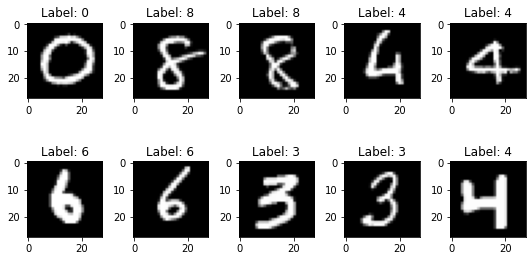

In [ ]:
def plot_samples():
  a, _, _ = get_fashion_mnist_dataloaders()
  num_row = 2
  num_col = 5# plot images
  num_images = num_row * num_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i, (x,y) in enumerate(a):
      if i >= num_images:
        break
      ax = axes[i//num_col, i%num_col]
      x = (x.numpy().squeeze() * 255).astype(int)
      y = y.numpy()[0]
      ax.imshow(x, cmap='gray')
      ax.set_title(f"Label: {y}")
      
  plt.tight_layout()
  plt.show()
plot_samples()

In [ ]:
# simple logger to track progress during training
class Logger:
    def __init__(self):
        self.losses_train = []
        self.losses_valid = []
        self.accuracies_train = []
        self.accuracies_valid = []

    def log(self, accuracy_train=0, loss_train=0, accuracy_valid=0, loss_valid=0):
        self.losses_train.append(loss_train)
        self.accuracies_train.append(accuracy_train)
        self.losses_valid.append(loss_valid)
        self.accuracies_valid.append(accuracy_valid)

    def plot_loss_and_accuracy(self, train=True, valid=True):

        assert train and valid, "Cannot plot accuracy because neither train nor valid."

        figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                            figsize=(12, 6))
        
        if train:
            ax1.plot(self.losses_train, label="Training")
            ax2.plot(self.accuracies_train, label="Training")
        if valid:
            ax1.plot(self.losses_valid, label="Validation")
            ax1.set_title("CrossEntropy Loss")
            ax2.plot(self.accuracies_valid, label="Validation")
            ax2.set_title("Accuracy")
        
        for ax in figure.axes:
            ax.set_xlabel("Epoch")
            ax.legend(loc='best')
            ax.set_axisbelow(True)
            ax.minorticks_on()
            ax.grid(True, which="major", linestyle='-')
            ax.grid(True, which="minor", linestyle='--', color='lightgrey', alpha=.4)            
  
    def print_last():
        print(f"Epoch {len(self.losses_train):2d}, \
                    Train:loss={self.losses_train[-1]:.3f}, accuracy={self.accuracies_train[-1]*100:.1f}%, \
                    Valid: loss={self.losses_valid[-1]:.3f}, accuracy={self.losses_valid[-1]*100:.1f}%", flush=True)

# RNN, LSTM, GRU

In [ ]:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

input_size = 28
hidden_size = 128
num_layers = 3
num_classes = 10 

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN, self).__init__()
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, _ = self.rnn(x, h0)  
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

input_size = 28
hidden_size = 64
num_layers = 2
num_classes = 10 

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(LSTM, self).__init__()
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        initial_hidden_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        initial_cell_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        output, _ = self.lstm(x, (initial_hidden_state,initial_cell_state))  
        return self.fc(output[:, -1, :]) # last time step
         

In [ ]:
# https://blog.floydhub.com/gru-with-pytorch/

input_size = 28
hidden_size = 64
num_layers = 2
num_classes = 10 

class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(GRU, self).__init__()
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)
      self.relu = nn.ReLU()

    def forward(self, x):
        
        initial_hidden_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        output, _ = self.gru(x, initial_hidden_state)
        output = self.fc(self.relu(output[:,-1])) # last time step
        return out

In [ ]:

def accuracy_and_loss_whole_dataset(data_loader, model, isTest):
  loss     = 0.
  criterion = nn.CrossEntropyLoss()
  n_correct = 0
  n_samples = 0
  missclassified_samples = []

  with torch.no_grad():

      for data, labels in data_loader:
          data = data.reshape(-1, 28, input_size)
          outputs = model(data)

          xentrp   =  criterion(outputs, labels)

          loss     = loss + xentrp.item()

          _, predicted = torch.max(outputs.data, 1)

          n_samples += outputs.shape[0]
          n_correct += (predicted == labels).sum().item()

      loss = loss / float(n_samples)

      acc =  n_correct / n_samples
      del n_samples

      if isTest:
        plot_confusion_matrix(labels, predicted, classes= [0,1,2,3,4,5,6,7,8,9],title='Confusion matrix, without normalization')


      return acc, loss, missclassified_samples

# Training


In [ ]:
def train(model, lr=0.1, nb_epochs=10, seed=None, data_loader_train=None, data_loader_val=None):
    best_model = None
    best_test_accuracy = 0
    best_accuracy = 0
    logger = Logger()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  

    total_losses = []

    t0 = time.time()
    for epoch in tqdm(range(nb_epochs)):
        if epoch > 0:
          for i, (data, labels) in enumerate(data_loader_train):  
          
              data = data.reshape(-1, 28, input_size) # reshape input 
    
              optimizer.zero_grad()
              outputs = model(data)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              
              total_losses.append(loss.item())


        accuracy_train, loss_train, _ = accuracy_and_loss_whole_dataset(data_loader_train, model, False)
        accuracy_val, loss_val, _ = accuracy_and_loss_whole_dataset(data_loader_val, model, False)
        
        if accuracy_val > best_accuracy:
          best_model = model
          best_val_accuracy = accuracy_val

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        if epoch % 1 == 0: # prints every 5 epochs, you can change it to % 1 for example to print each epoch


          print((np.array(total_losses).sum())/ len(total_losses))

          print(f"Epoch {epoch:2d}, \
                  Train: loss={loss_train:.3f}, accuracy={accuracy_train*100:.1f}%, \
                  Valid: loss={loss_val:.3f}, accuracy={accuracy_val*100:.1f}%", flush=True)
          

          total_losses = []

    t1 = time.time()
    print('\n The total time for training in seconds is')
    print(t1-t0)

    return best_model, best_val_accuracy, logger


In [ ]:
from torchsummaryX import summary as s
# !pip3 install torchsummaryX



  0%|          | 0/75 [00:00<?, ?it/s]

nan
Epoch  0,                   Train: loss=0.023, accuracy=9.7%,                   Valid: loss=0.023, accuracy=9.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


  1%|▏         | 1/75 [00:09<12:03,  9.78s/it]

2.2611307391413935
Epoch  1,                   Train: loss=0.021, accuracy=25.4%,                   Valid: loss=0.021, accuracy=26.8%




  3%|▎         | 2/75 [00:36<18:06, 14.88s/it]

1.6097903412801249
Epoch  2,                   Train: loss=0.013, accuracy=52.6%,                   Valid: loss=0.013, accuracy=53.7%




  4%|▍         | 3/75 [01:03<22:18, 18.59s/it]

1.2239961919961153
Epoch  3,                   Train: loss=0.011, accuracy=62.1%,                   Valid: loss=0.011, accuracy=64.2%




  5%|▌         | 4/75 [01:30<24:54, 21.05s/it]

0.9859481430715985
Epoch  4,                   Train: loss=0.008, accuracy=72.3%,                   Valid: loss=0.008, accuracy=74.0%




  7%|▋         | 5/75 [01:57<26:40, 22.86s/it]

0.7669125349433333
Epoch  5,                   Train: loss=0.007, accuracy=79.1%,                   Valid: loss=0.006, accuracy=79.8%




  8%|▊         | 6/75 [02:24<27:41, 24.08s/it]

0.6480856683519152
Epoch  6,                   Train: loss=0.006, accuracy=80.6%,                   Valid: loss=0.006, accuracy=82.1%




  9%|▉         | 7/75 [02:51<28:14, 24.92s/it]

0.5376523143163434
Epoch  7,                   Train: loss=0.004, accuracy=87.6%,                   Valid: loss=0.004, accuracy=88.4%




 11%|█         | 8/75 [03:18<28:27, 25.49s/it]

0.43097352046105597
Epoch  8,                   Train: loss=0.004, accuracy=89.8%,                   Valid: loss=0.004, accuracy=89.8%




 12%|█▏        | 9/75 [03:45<28:26, 25.85s/it]

0.3615462007621924
Epoch  9,                   Train: loss=0.003, accuracy=91.3%,                   Valid: loss=0.003, accuracy=91.7%




 13%|█▎        | 10/75 [04:11<28:19, 26.15s/it]

0.3216672288046943
Epoch 10,                   Train: loss=0.003, accuracy=92.3%,                   Valid: loss=0.003, accuracy=92.5%




 15%|█▍        | 11/75 [04:38<28:04, 26.32s/it]

0.28603109060614196
Epoch 11,                   Train: loss=0.003, accuracy=92.7%,                   Valid: loss=0.003, accuracy=92.4%




 16%|█▌        | 12/75 [05:05<27:47, 26.47s/it]

0.26593432656868743
Epoch 12,                   Train: loss=0.002, accuracy=93.6%,                   Valid: loss=0.002, accuracy=93.5%




 17%|█▋        | 13/75 [05:32<27:27, 26.56s/it]

0.2482640485934637
Epoch 13,                   Train: loss=0.002, accuracy=93.7%,                   Valid: loss=0.002, accuracy=93.7%




 19%|█▊        | 14/75 [05:58<27:02, 26.59s/it]

0.22403542295926146
Epoch 14,                   Train: loss=0.002, accuracy=93.5%,                   Valid: loss=0.002, accuracy=93.5%




 20%|██        | 15/75 [06:25<26:37, 26.63s/it]

0.215367875220599
Epoch 15,                   Train: loss=0.002, accuracy=94.7%,                   Valid: loss=0.002, accuracy=94.4%




 21%|██▏       | 16/75 [06:52<26:23, 26.84s/it]

0.20568438146125387
Epoch 16,                   Train: loss=0.002, accuracy=94.1%,                   Valid: loss=0.002, accuracy=94.1%




 23%|██▎       | 17/75 [07:20<26:02, 26.94s/it]

0.19060403894357109
Epoch 17,                   Train: loss=0.002, accuracy=94.4%,                   Valid: loss=0.002, accuracy=94.2%




 24%|██▍       | 18/75 [07:46<25:35, 26.93s/it]

0.18190576943258444
Epoch 18,                   Train: loss=0.002, accuracy=93.8%,                   Valid: loss=0.002, accuracy=93.7%




 25%|██▌       | 19/75 [08:13<25:07, 26.92s/it]

0.17188510804402607
Epoch 19,                   Train: loss=0.002, accuracy=95.6%,                   Valid: loss=0.002, accuracy=95.1%




 27%|██▋       | 20/75 [08:40<24:39, 26.91s/it]

0.1632552584460764
Epoch 20,                   Train: loss=0.001, accuracy=95.9%,                   Valid: loss=0.002, accuracy=95.3%




 28%|██▊       | 21/75 [09:07<24:12, 26.90s/it]

0.15677862296018888
Epoch 21,                   Train: loss=0.001, accuracy=95.8%,                   Valid: loss=0.002, accuracy=95.5%




 29%|██▉       | 22/75 [09:34<23:44, 26.88s/it]

0.15316275890433678
Epoch 22,                   Train: loss=0.001, accuracy=95.9%,                   Valid: loss=0.002, accuracy=95.7%




 31%|███       | 23/75 [10:01<23:16, 26.85s/it]

0.1459243997828
Epoch 23,                   Train: loss=0.001, accuracy=96.4%,                   Valid: loss=0.001, accuracy=96.0%




 32%|███▏      | 24/75 [10:28<22:48, 26.83s/it]

0.14225551688146812
Epoch 24,                   Train: loss=0.001, accuracy=96.4%,                   Valid: loss=0.001, accuracy=95.8%




 33%|███▎      | 25/75 [10:54<22:22, 26.85s/it]

0.13631554891320843
Epoch 25,                   Train: loss=0.001, accuracy=96.5%,                   Valid: loss=0.001, accuracy=96.1%




 35%|███▍      | 26/75 [11:22<22:00, 26.95s/it]

0.13031117425265687
Epoch 26,                   Train: loss=0.001, accuracy=96.2%,                   Valid: loss=0.002, accuracy=95.8%




 36%|███▌      | 27/75 [11:48<21:30, 26.89s/it]

0.12438263979016079
Epoch 27,                   Train: loss=0.001, accuracy=96.7%,                   Valid: loss=0.001, accuracy=96.1%




 37%|███▋      | 28/75 [12:15<21:03, 26.89s/it]

0.12274097756448167
Epoch 28,                   Train: loss=0.001, accuracy=97.0%,                   Valid: loss=0.001, accuracy=96.4%




 39%|███▊      | 29/75 [12:42<20:35, 26.86s/it]

0.1194074335783996
Epoch 29,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.1%




 40%|████      | 30/75 [13:09<20:07, 26.84s/it]

0.11474035170826095
Epoch 30,                   Train: loss=0.001, accuracy=97.0%,                   Valid: loss=0.001, accuracy=96.3%




 41%|████▏     | 31/75 [13:36<19:39, 26.81s/it]

0.11159356119352634
Epoch 31,                   Train: loss=0.001, accuracy=97.2%,                   Valid: loss=0.001, accuracy=96.5%




 43%|████▎     | 32/75 [14:02<19:11, 26.79s/it]

0.11033085497027194
Epoch 32,                   Train: loss=0.001, accuracy=97.0%,                   Valid: loss=0.001, accuracy=96.6%




 44%|████▍     | 33/75 [14:29<18:44, 26.77s/it]

0.10412606442243688
Epoch 33,                   Train: loss=0.001, accuracy=97.1%,                   Valid: loss=0.001, accuracy=96.4%




 45%|████▌     | 34/75 [14:56<18:17, 26.77s/it]

0.10101023355878337
Epoch 34,                   Train: loss=0.001, accuracy=96.1%,                   Valid: loss=0.001, accuracy=95.6%




 47%|████▋     | 35/75 [15:23<17:52, 26.81s/it]

0.10010935846302245
Epoch 35,                   Train: loss=0.001, accuracy=97.1%,                   Valid: loss=0.001, accuracy=96.5%




 48%|████▊     | 36/75 [15:50<17:26, 26.83s/it]

0.0969295900211566
Epoch 36,                   Train: loss=0.001, accuracy=97.3%,                   Valid: loss=0.001, accuracy=96.7%




 49%|████▉     | 37/75 [16:16<16:58, 26.81s/it]

0.09690826203915533
Epoch 37,                   Train: loss=0.001, accuracy=97.5%,                   Valid: loss=0.001, accuracy=96.8%




 51%|█████     | 38/75 [16:43<16:32, 26.81s/it]

0.09388778892311234
Epoch 38,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=97.0%




 52%|█████▏    | 39/75 [17:10<16:05, 26.81s/it]

0.09167741898930183
Epoch 39,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=97.0%




 53%|█████▎    | 40/75 [17:37<15:38, 26.80s/it]

0.08852768969394405
Epoch 40,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=97.0%




 55%|█████▍    | 41/75 [18:04<15:11, 26.80s/it]

0.0861315944749448
Epoch 41,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.2%




 56%|█████▌    | 42/75 [18:30<14:43, 26.77s/it]

0.08561439785450974
Epoch 42,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.0%




 57%|█████▋    | 43/75 [18:57<14:15, 26.75s/it]

0.08264893205250028
Epoch 43,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.3%




 59%|█████▊    | 44/75 [19:24<13:50, 26.78s/it]

0.08105045747598288
Epoch 44,                   Train: loss=0.001, accuracy=98.0%,                   Valid: loss=0.001, accuracy=97.5%




 60%|██████    | 45/75 [19:50<13:22, 26.76s/it]

0.08089181941813203
Epoch 45,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.5%




 61%|██████▏   | 46/75 [20:17<12:55, 26.74s/it]

0.07823640831090786
Epoch 46,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.4%




 63%|██████▎   | 47/75 [20:44<12:28, 26.73s/it]

0.07565055176339767
Epoch 47,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.4%




 64%|██████▍   | 48/75 [21:11<12:01, 26.74s/it]

0.07301945695998492
Epoch 48,                   Train: loss=0.001, accuracy=97.3%,                   Valid: loss=0.001, accuracy=96.9%




 65%|██████▌   | 49/75 [21:38<11:36, 26.79s/it]

0.07282742169961609
Epoch 49,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.4%




 67%|██████▋   | 50/75 [22:04<11:09, 26.79s/it]

0.07156553865255168
Epoch 50,                   Train: loss=0.001, accuracy=98.2%,                   Valid: loss=0.001, accuracy=97.7%




 68%|██████▊   | 51/75 [22:31<10:43, 26.82s/it]

0.0713833304691232
Epoch 51,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.6%




 69%|██████▉   | 52/75 [22:58<10:18, 26.89s/it]

0.0711479846664049
Epoch 52,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.5%




 71%|███████   | 53/75 [23:25<09:50, 26.84s/it]

0.0688312203735458
Epoch 53,                   Train: loss=0.001, accuracy=98.4%,                   Valid: loss=0.001, accuracy=97.6%




 72%|███████▏  | 54/75 [23:52<09:24, 26.87s/it]

0.0662046984890131
Epoch 54,                   Train: loss=0.001, accuracy=98.3%,                   Valid: loss=0.001, accuracy=97.7%




 73%|███████▎  | 55/75 [24:19<08:59, 26.98s/it]

0.06480860648228338
Epoch 55,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.5%




 75%|███████▍  | 56/75 [24:46<08:32, 26.96s/it]

0.06350392061458142
Epoch 56,                   Train: loss=0.001, accuracy=98.6%,                   Valid: loss=0.001, accuracy=98.0%




 76%|███████▌  | 57/75 [25:13<08:05, 26.97s/it]

0.06476412856330474
Epoch 57,                   Train: loss=0.001, accuracy=98.4%,                   Valid: loss=0.001, accuracy=97.6%




 77%|███████▋  | 58/75 [25:40<07:38, 26.94s/it]

0.0627860767663353
Epoch 58,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.5%




 79%|███████▊  | 59/75 [26:07<07:10, 26.93s/it]

0.05979584301132019
Epoch 59,                   Train: loss=0.001, accuracy=98.2%,                   Valid: loss=0.001, accuracy=97.5%




 80%|████████  | 60/75 [26:34<06:43, 26.89s/it]

0.06145113066735643
Epoch 60,                   Train: loss=0.001, accuracy=98.4%,                   Valid: loss=0.001, accuracy=97.7%




 81%|████████▏ | 61/75 [27:01<06:17, 26.96s/it]

0.05909550559396545
Epoch 61,                   Train: loss=0.001, accuracy=98.5%,                   Valid: loss=0.001, accuracy=97.8%




 83%|████████▎ | 62/75 [27:28<05:49, 26.91s/it]

0.058311073459615864
Epoch 62,                   Train: loss=0.001, accuracy=98.6%,                   Valid: loss=0.001, accuracy=97.7%




 84%|████████▍ | 63/75 [27:55<05:23, 26.96s/it]

0.05841819266357494
Epoch 63,                   Train: loss=0.001, accuracy=98.5%,                   Valid: loss=0.001, accuracy=97.6%




 85%|████████▌ | 64/75 [28:22<04:57, 27.07s/it]

0.056571370301147304
Epoch 64,                   Train: loss=0.000, accuracy=98.7%,                   Valid: loss=0.001, accuracy=97.9%




 87%|████████▋ | 65/75 [28:49<04:30, 27.03s/it]

0.05521921344118676
Epoch 65,                   Train: loss=0.000, accuracy=98.8%,                   Valid: loss=0.001, accuracy=98.0%




 88%|████████▊ | 66/75 [29:16<04:02, 26.97s/it]

0.05480839328460947
Epoch 66,                   Train: loss=0.000, accuracy=98.6%,                   Valid: loss=0.001, accuracy=97.8%




 89%|████████▉ | 67/75 [29:42<03:35, 26.90s/it]

0.05476392491513656
Epoch 67,                   Train: loss=0.001, accuracy=98.6%,                   Valid: loss=0.001, accuracy=97.8%




 91%|█████████ | 68/75 [30:09<03:08, 26.86s/it]

0.0528109930438438
Epoch 68,                   Train: loss=0.001, accuracy=98.3%,                   Valid: loss=0.001, accuracy=97.7%




 92%|█████████▏| 69/75 [30:36<02:41, 26.89s/it]

0.05411722268478048
Epoch 69,                   Train: loss=0.000, accuracy=98.6%,                   Valid: loss=0.001, accuracy=97.9%




 93%|█████████▎| 70/75 [31:03<02:14, 26.88s/it]

0.05238934214985757
Epoch 70,                   Train: loss=0.000, accuracy=98.7%,                   Valid: loss=0.001, accuracy=98.0%




 95%|█████████▍| 71/75 [31:30<01:47, 26.87s/it]

0.0514709478330419
Epoch 71,                   Train: loss=0.000, accuracy=98.8%,                   Valid: loss=0.001, accuracy=98.0%




 96%|█████████▌| 72/75 [31:57<01:20, 26.85s/it]

0.04930701902808828
Epoch 72,                   Train: loss=0.000, accuracy=98.6%,                   Valid: loss=0.001, accuracy=97.7%




 97%|█████████▋| 73/75 [32:24<00:53, 26.86s/it]

0.04973876497846235
Epoch 73,                   Train: loss=0.001, accuracy=98.5%,                   Valid: loss=0.001, accuracy=97.8%




 99%|█████████▊| 74/75 [32:50<00:26, 26.85s/it]

0.04859314303482986
Epoch 74,                   Train: loss=0.000, accuracy=98.7%,                   Valid: loss=0.001, accuracy=97.9%




100%|██████████| 75/75 [33:17<00:00, 26.64s/it]


 The total time for training in seconds is
1997.7280542850494
Best validation accuracy = 97.917


Confusion matrix, without normalization
Evaluation of the best training model over test set
------
Loss : 0.001
Accuracy : 97.690


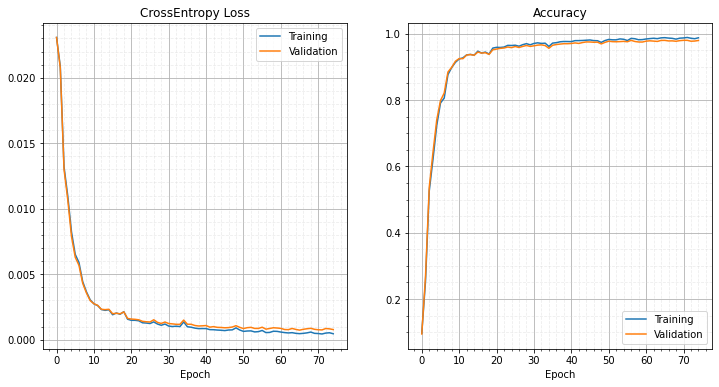

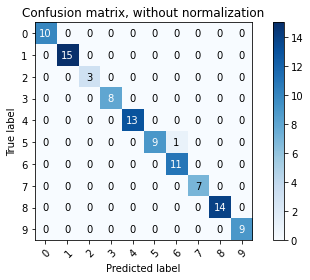

In [ ]:
batch_size = 100 
lr = 0.01 

data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

model = RNN(input_size, hidden_size, num_layers, num_classes)

# s(model, torch.zeros((1, 28, 28)))

best_model, best_val_accuracy, logger = train(model,lr=lr, nb_epochs=75,data_loader_train=data_loader_train, data_loader_val=data_loader_val)
logger.plot_loss_and_accuracy()
print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

accuracy_test, loss_test, misclassified_samples = accuracy_and_loss_whole_dataset(data_loader_test, best_model, True)

print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

In [ ]:

model = LSTM(input_size, hidden_size, num_layers, num_classes)

s(model, torch.zeros((1, 28, 28)))


       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -  [1, 28, 64]   57344      56320
1_fc       [64, 10]      [1, 10]     650        640
---------------------------------------------------
                      Totals
Total params           57994
Trainable params       57994
Non-trainable params       0
Mult-Adds              56960


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[1, 28, 64]",57344,56320
1_fc,"[64, 10]","[1, 10]",650,640




  0%|          | 0/75 [00:00<?, ?it/s]

nan
Epoch  0,                   Train: loss=0.023, accuracy=9.9%,                   Valid: loss=0.023, accuracy=9.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


  1%|▏         | 1/75 [00:21<26:13, 21.27s/it]

2.3026041830027544
Epoch  1,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




  3%|▎         | 2/75 [01:32<44:11, 36.32s/it]

2.3006369083016005
Epoch  2,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




  4%|▍         | 3/75 [02:44<56:13, 46.86s/it]

2.2998143836303995
Epoch  3,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




  5%|▌         | 4/75 [03:55<1:04:11, 54.25s/it]

2.299184646871355
Epoch  4,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




  7%|▋         | 5/75 [05:07<1:09:20, 59.43s/it]

2.2985323702847515
Epoch  5,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




  8%|▊         | 6/75 [06:18<1:12:25, 62.97s/it]

2.2977689782778423
Epoch  6,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




  9%|▉         | 7/75 [07:29<1:14:14, 65.51s/it]

2.2968414655438174
Epoch  7,                   Train: loss=0.023, accuracy=11.2%,                   Valid: loss=0.023, accuracy=11.2%




 11%|█         | 8/75 [08:41<1:15:03, 67.21s/it]

2.29566441377004
Epoch  8,                   Train: loss=0.023, accuracy=11.4%,                   Valid: loss=0.023, accuracy=11.3%




 12%|█▏        | 9/75 [09:52<1:15:14, 68.41s/it]

2.2940936145959077
Epoch  9,                   Train: loss=0.023, accuracy=11.7%,                   Valid: loss=0.023, accuracy=11.6%




 13%|█▎        | 10/75 [11:03<1:14:58, 69.20s/it]

2.2918872541851467
Epoch 10,                   Train: loss=0.023, accuracy=13.3%,                   Valid: loss=0.023, accuracy=12.9%




 15%|█▍        | 11/75 [12:14<1:14:28, 69.82s/it]

2.2885335586689135
Epoch 11,                   Train: loss=0.023, accuracy=15.1%,                   Valid: loss=0.023, accuracy=15.0%




 16%|█▌        | 12/75 [13:25<1:13:45, 70.24s/it]

2.282716788627483
Epoch 12,                   Train: loss=0.023, accuracy=19.2%,                   Valid: loss=0.023, accuracy=18.9%




 17%|█▋        | 13/75 [14:37<1:12:57, 70.60s/it]

2.269751122262743
Epoch 13,                   Train: loss=0.023, accuracy=21.4%,                   Valid: loss=0.023, accuracy=20.6%




 19%|█▊        | 14/75 [15:48<1:12:02, 70.86s/it]

2.2182389387377985
Epoch 14,                   Train: loss=0.022, accuracy=22.7%,                   Valid: loss=0.022, accuracy=22.9%




 20%|██        | 15/75 [17:00<1:11:01, 71.02s/it]

2.088659968861827
Epoch 15,                   Train: loss=0.020, accuracy=23.8%,                   Valid: loss=0.020, accuracy=24.2%




 21%|██▏       | 16/75 [18:11<1:09:57, 71.15s/it]

1.9961999890980897
Epoch 16,                   Train: loss=0.020, accuracy=27.7%,                   Valid: loss=0.020, accuracy=27.6%




 23%|██▎       | 17/75 [19:23<1:08:55, 71.30s/it]

1.8900966637664371
Epoch 17,                   Train: loss=0.018, accuracy=34.7%,                   Valid: loss=0.018, accuracy=34.2%




 24%|██▍       | 18/75 [20:34<1:07:43, 71.29s/it]

1.7073696399176563
Epoch 18,                   Train: loss=0.016, accuracy=46.9%,                   Valid: loss=0.016, accuracy=47.6%




 25%|██▌       | 19/75 [21:46<1:06:37, 71.38s/it]

1.4041833619276682
Epoch 19,                   Train: loss=0.012, accuracy=57.5%,                   Valid: loss=0.013, accuracy=57.9%




 27%|██▋       | 20/75 [22:57<1:05:22, 71.32s/it]

1.1323225443009977
Epoch 20,                   Train: loss=0.010, accuracy=67.1%,                   Valid: loss=0.010, accuracy=67.3%




 28%|██▊       | 21/75 [24:08<1:04:12, 71.34s/it]

0.9364046387098454
Epoch 21,                   Train: loss=0.009, accuracy=71.4%,                   Valid: loss=0.008, accuracy=71.7%




 29%|██▉       | 22/75 [25:19<1:03:02, 71.36s/it]

0.8089979362708551
Epoch 22,                   Train: loss=0.007, accuracy=75.2%,                   Valid: loss=0.007, accuracy=75.7%




 31%|███       | 23/75 [26:31<1:01:51, 71.38s/it]

0.6941353581017918
Epoch 23,                   Train: loss=0.006, accuracy=79.8%,                   Valid: loss=0.006, accuracy=80.1%




 32%|███▏      | 24/75 [27:42<1:00:40, 71.38s/it]

0.5931266840961245
Epoch 24,                   Train: loss=0.005, accuracy=83.0%,                   Valid: loss=0.005, accuracy=82.9%




 33%|███▎      | 25/75 [28:54<59:29, 71.40s/it]  

0.5044962667204715
Epoch 25,                   Train: loss=0.004, accuracy=86.5%,                   Valid: loss=0.004, accuracy=86.7%




 35%|███▍      | 26/75 [30:05<58:16, 71.36s/it]

0.4312203925792818
Epoch 26,                   Train: loss=0.004, accuracy=87.8%,                   Valid: loss=0.004, accuracy=87.9%




 36%|███▌      | 27/75 [31:16<57:05, 71.37s/it]

0.3702185807404695
Epoch 27,                   Train: loss=0.003, accuracy=90.3%,                   Valid: loss=0.003, accuracy=90.3%




 37%|███▋      | 28/75 [32:28<55:53, 71.36s/it]

0.3203677938216262
Epoch 28,                   Train: loss=0.003, accuracy=91.6%,                   Valid: loss=0.003, accuracy=91.7%




 39%|███▊      | 29/75 [33:39<54:44, 71.40s/it]

0.2854715654971423
Epoch 29,                   Train: loss=0.003, accuracy=91.2%,                   Valid: loss=0.003, accuracy=91.1%




 40%|████      | 30/75 [34:51<53:34, 71.43s/it]

0.2567178024461976
Epoch 30,                   Train: loss=0.003, accuracy=91.0%,                   Valid: loss=0.003, accuracy=91.1%




 41%|████▏     | 31/75 [36:03<52:28, 71.55s/it]

0.23547287168050254
Epoch 31,                   Train: loss=0.002, accuracy=93.9%,                   Valid: loss=0.002, accuracy=94.2%




 43%|████▎     | 32/75 [37:14<51:17, 71.58s/it]

0.21383833616144127
Epoch 32,                   Train: loss=0.002, accuracy=94.3%,                   Valid: loss=0.002, accuracy=94.5%




 44%|████▍     | 33/75 [38:26<50:05, 71.57s/it]

0.20079470018821735
Epoch 33,                   Train: loss=0.002, accuracy=94.4%,                   Valid: loss=0.002, accuracy=94.5%




 45%|████▌     | 34/75 [39:37<48:55, 71.61s/it]

0.18556251507942323
Epoch 34,                   Train: loss=0.002, accuracy=95.3%,                   Valid: loss=0.002, accuracy=95.2%




 47%|████▋     | 35/75 [40:49<47:45, 71.65s/it]

0.17702606610815835
Epoch 35,                   Train: loss=0.002, accuracy=94.8%,                   Valid: loss=0.002, accuracy=94.9%




 48%|████▊     | 36/75 [42:01<46:31, 71.58s/it]

0.16481553151927614
Epoch 36,                   Train: loss=0.002, accuracy=95.2%,                   Valid: loss=0.002, accuracy=94.9%




 49%|████▉     | 37/75 [43:12<45:18, 71.53s/it]

0.1584383658029967
Epoch 37,                   Train: loss=0.001, accuracy=95.8%,                   Valid: loss=0.001, accuracy=95.8%




 51%|█████     | 38/75 [44:24<44:08, 71.57s/it]

0.1508305411061479
Epoch 38,                   Train: loss=0.001, accuracy=96.1%,                   Valid: loss=0.001, accuracy=96.2%




 52%|█████▏    | 39/75 [45:35<42:56, 71.58s/it]

0.1439744372576199
Epoch 39,                   Train: loss=0.001, accuracy=96.1%,                   Valid: loss=0.001, accuracy=95.8%




 53%|█████▎    | 40/75 [46:47<41:44, 71.57s/it]

0.13833069073174287
Epoch 40,                   Train: loss=0.001, accuracy=96.5%,                   Valid: loss=0.001, accuracy=96.5%




 55%|█████▍    | 41/75 [47:58<40:32, 71.54s/it]

0.1343814954161644
Epoch 41,                   Train: loss=0.001, accuracy=96.2%,                   Valid: loss=0.001, accuracy=95.9%




 56%|█████▌    | 42/75 [49:10<39:24, 71.66s/it]

0.128615342773911
Epoch 42,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.5%




 57%|█████▋    | 43/75 [50:22<38:14, 71.71s/it]

0.12334465715965187
Epoch 43,                   Train: loss=0.001, accuracy=96.3%,                   Valid: loss=0.001, accuracy=96.4%




 59%|█████▊    | 44/75 [51:33<37:00, 71.63s/it]

0.1215626695331324
Epoch 44,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.5%




 60%|██████    | 45/75 [52:45<35:49, 71.65s/it]

0.11749885856967282
Epoch 45,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.3%




 61%|██████▏   | 46/75 [53:57<34:37, 71.64s/it]

0.11339066373184323
Epoch 46,                   Train: loss=0.001, accuracy=97.1%,                   Valid: loss=0.001, accuracy=96.6%




 63%|██████▎   | 47/75 [55:08<33:25, 71.64s/it]

0.10984891300193138
Epoch 47,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.5%




 64%|██████▍   | 48/75 [56:20<32:14, 71.64s/it]

0.10834591681551602
Epoch 48,                   Train: loss=0.001, accuracy=97.2%,                   Valid: loss=0.001, accuracy=96.8%




 65%|██████▌   | 49/75 [57:32<31:01, 71.59s/it]

0.10454194096296474
Epoch 49,                   Train: loss=0.001, accuracy=97.1%,                   Valid: loss=0.001, accuracy=96.7%




 67%|██████▋   | 50/75 [58:43<29:48, 71.54s/it]

0.10227692525971818
Epoch 50,                   Train: loss=0.001, accuracy=96.4%,                   Valid: loss=0.001, accuracy=96.1%




 68%|██████▊   | 51/75 [59:54<28:35, 71.49s/it]

0.10098916066775995
Epoch 51,                   Train: loss=0.001, accuracy=97.2%,                   Valid: loss=0.001, accuracy=96.9%




 69%|██████▉   | 52/75 [1:01:06<27:25, 71.54s/it]

0.09681636268893877
Epoch 52,                   Train: loss=0.001, accuracy=97.3%,                   Valid: loss=0.001, accuracy=97.0%




 71%|███████   | 53/75 [1:02:18<26:15, 71.59s/it]

0.09346465915786448
Epoch 53,                   Train: loss=0.001, accuracy=96.7%,                   Valid: loss=0.001, accuracy=96.3%




 72%|███████▏  | 54/75 [1:03:29<25:03, 71.61s/it]

0.091646021499333
Epoch 54,                   Train: loss=0.001, accuracy=97.5%,                   Valid: loss=0.001, accuracy=97.1%




 73%|███████▎  | 55/75 [1:04:41<23:52, 71.64s/it]

0.0907380827995776
Epoch 55,                   Train: loss=0.001, accuracy=97.4%,                   Valid: loss=0.001, accuracy=97.1%




 75%|███████▍  | 56/75 [1:05:53<22:43, 71.74s/it]

0.08796591060408564
Epoch 56,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=97.2%




 76%|███████▌  | 57/75 [1:07:05<21:31, 71.73s/it]

0.08737409401478038
Epoch 57,                   Train: loss=0.001, accuracy=97.3%,                   Valid: loss=0.001, accuracy=96.9%




 77%|███████▋  | 58/75 [1:08:17<20:19, 71.73s/it]

0.08417723130572725
Epoch 58,                   Train: loss=0.001, accuracy=97.7%,                   Valid: loss=0.001, accuracy=97.4%




 79%|███████▊  | 59/75 [1:09:28<19:07, 71.71s/it]

0.08499338776218118
Epoch 59,                   Train: loss=0.001, accuracy=97.7%,                   Valid: loss=0.001, accuracy=97.4%




 80%|████████  | 60/75 [1:10:40<17:55, 71.67s/it]

0.08161166708364531
Epoch 60,                   Train: loss=0.001, accuracy=97.7%,                   Valid: loss=0.001, accuracy=97.2%




 81%|████████▏ | 61/75 [1:11:52<16:44, 71.72s/it]

0.08066231056840883
Epoch 61,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.4%




 83%|████████▎ | 62/75 [1:13:03<15:31, 71.63s/it]

0.07766661734613417
Epoch 62,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.3%




 84%|████████▍ | 63/75 [1:14:15<14:19, 71.64s/it]

0.07726291035715904
Epoch 63,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.1%




 85%|████████▌ | 64/75 [1:15:26<13:07, 71.61s/it]

0.07596886720232389
Epoch 64,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.7%




 87%|████████▋ | 65/75 [1:16:38<11:56, 71.63s/it]

0.07448269722603813
Epoch 65,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.4%




 88%|████████▊ | 66/75 [1:17:50<10:44, 71.67s/it]

0.07269942926035987
Epoch 66,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.2%




 89%|████████▉ | 67/75 [1:19:01<09:33, 71.65s/it]

0.0717024099211105
Epoch 67,                   Train: loss=0.001, accuracy=98.0%,                   Valid: loss=0.001, accuracy=97.5%




 91%|█████████ | 68/75 [1:20:13<08:21, 71.66s/it]

0.07048468590300117
Epoch 68,                   Train: loss=0.001, accuracy=97.7%,                   Valid: loss=0.001, accuracy=97.3%




 92%|█████████▏| 69/75 [1:21:25<07:10, 71.77s/it]

0.06944921048427069
Epoch 69,                   Train: loss=0.001, accuracy=98.0%,                   Valid: loss=0.001, accuracy=97.5%




 93%|█████████▎| 70/75 [1:22:37<05:58, 71.76s/it]

0.0668005450801165
Epoch 70,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.6%




 95%|█████████▍| 71/75 [1:23:48<04:46, 71.72s/it]

0.0653224923716927
Epoch 71,                   Train: loss=0.001, accuracy=98.1%,                   Valid: loss=0.001, accuracy=97.8%




 96%|█████████▌| 72/75 [1:25:00<03:35, 71.72s/it]

0.0650869732601913
Epoch 72,                   Train: loss=0.001, accuracy=98.3%,                   Valid: loss=0.001, accuracy=97.7%




 97%|█████████▋| 73/75 [1:26:12<02:23, 71.83s/it]

0.06287659646908718
Epoch 73,                   Train: loss=0.001, accuracy=98.2%,                   Valid: loss=0.001, accuracy=97.4%




 99%|█████████▊| 74/75 [1:27:24<01:11, 71.86s/it]

0.06317623344474231
Epoch 74,                   Train: loss=0.001, accuracy=98.4%,                   Valid: loss=0.001, accuracy=97.9%




100%|██████████| 75/75 [1:28:36<00:00, 70.89s/it]


 The total time for training in seconds is
5316.485952615738
Best validation accuracy = 97.850


Confusion matrix, without normalization
Evaluation of the best training model over test set
------
Loss : 0.001
Accuracy : 97.940


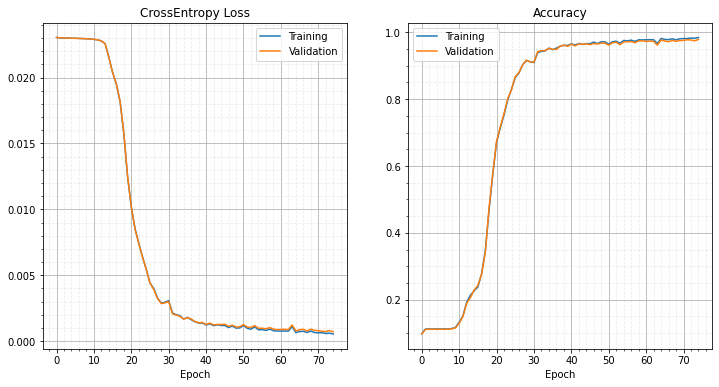

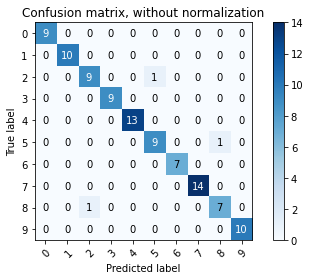

In [ ]:
batch_size = 100 
lr = 0.01 

data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

model = LSTM(input_size, hidden_size, num_layers, num_classes)
best_model, best_val_accuracy, logger = train(model,lr=lr, nb_epochs=75,data_loader_train=data_loader_train, data_loader_val=data_loader_val)
logger.plot_loss_and_accuracy()
print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

accuracy_test, loss_test, misclassified_samples = accuracy_and_loss_whole_dataset(data_loader_test, best_model, True)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

In [ ]:
model = GRU(input_size, hidden_size, num_layers, num_classes)

s(model, torch.zeros((1, 28, 28)))



       Kernel Shape Output Shape   Params Mult-Adds
Layer                                              
0_gru             -  [1, 28, 64]  43.008k    42.24k
1_relu            -      [1, 64]        -         -
2_fc       [64, 10]      [1, 10]    650.0     640.0
----------------------------------------------------
                       Totals
Total params          43.658k
Trainable params      43.658k
Non-trainable params      0.0
Mult-Adds              42.88k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_gru,-,"[1, 28, 64]",43008.0,42240.0
1_relu,-,"[1, 64]",NaN,NaN
2_fc,"[64, 10]","[1, 10]",650.0,640.0




  0%|          | 0/75 [00:00<?, ?it/s]

nan
Epoch  0,                   Train: loss=0.023, accuracy=11.3%,                   Valid: loss=0.023, accuracy=10.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


  1%|▏         | 1/75 [00:17<21:30, 17.44s/it]

2.299401169794577
Epoch  1,                   Train: loss=0.023, accuracy=11.3%,                   Valid: loss=0.023, accuracy=10.9%




  3%|▎         | 2/75 [01:15<36:02, 29.63s/it]

2.2935313251283436
Epoch  2,                   Train: loss=0.023, accuracy=11.5%,                   Valid: loss=0.023, accuracy=11.2%




  4%|▍         | 3/75 [02:13<45:49, 38.19s/it]

2.2865613328086005
Epoch  3,                   Train: loss=0.023, accuracy=14.3%,                   Valid: loss=0.023, accuracy=14.0%




  5%|▌         | 4/75 [03:11<52:17, 44.19s/it]

2.2739043143060473
Epoch  4,                   Train: loss=0.023, accuracy=20.5%,                   Valid: loss=0.023, accuracy=20.2%




  7%|▋         | 5/75 [04:10<56:27, 48.40s/it]

2.2446382173785455
Epoch  5,                   Train: loss=0.022, accuracy=28.0%,                   Valid: loss=0.022, accuracy=28.0%




  8%|▊         | 6/75 [05:08<58:59, 51.30s/it]

2.1595878691584978
Epoch  6,                   Train: loss=0.021, accuracy=29.0%,                   Valid: loss=0.021, accuracy=28.6%




  9%|▉         | 7/75 [06:06<1:00:27, 53.35s/it]

1.992656876201983
Epoch  7,                   Train: loss=0.019, accuracy=33.1%,                   Valid: loss=0.019, accuracy=32.7%




 11%|█         | 8/75 [07:04<1:01:11, 54.80s/it]

1.8446223435578524
Epoch  8,                   Train: loss=0.018, accuracy=39.1%,                   Valid: loss=0.018, accuracy=38.7%




 12%|█▏        | 9/75 [08:02<1:01:28, 55.89s/it]

1.6964031828774346
Epoch  9,                   Train: loss=0.016, accuracy=45.8%,                   Valid: loss=0.016, accuracy=45.6%




 13%|█▎        | 10/75 [09:00<1:01:13, 56.52s/it]

1.5048822257253858
Epoch 10,                   Train: loss=0.014, accuracy=54.3%,                   Valid: loss=0.014, accuracy=54.1%




 15%|█▍        | 11/75 [09:58<1:00:47, 56.99s/it]

1.2895190879150673
Epoch 11,                   Train: loss=0.012, accuracy=59.8%,                   Valid: loss=0.012, accuracy=59.4%




 16%|█▌        | 12/75 [10:57<1:00:10, 57.31s/it]

1.1225553019179237
Epoch 12,                   Train: loss=0.011, accuracy=63.8%,                   Valid: loss=0.011, accuracy=63.2%




 17%|█▋        | 13/75 [11:54<59:24, 57.48s/it]  

1.0193687417992838
Epoch 13,                   Train: loss=0.010, accuracy=66.5%,                   Valid: loss=0.010, accuracy=65.0%




 19%|█▊        | 14/75 [12:52<58:34, 57.62s/it]

0.9524361826755382
Epoch 14,                   Train: loss=0.009, accuracy=69.0%,                   Valid: loss=0.009, accuracy=67.5%




 20%|██        | 15/75 [13:50<57:44, 57.74s/it]

0.8970167406179287
Epoch 15,                   Train: loss=0.009, accuracy=71.4%,                   Valid: loss=0.009, accuracy=70.1%




 21%|██▏       | 16/75 [14:49<56:54, 57.88s/it]

0.8436416895301254
Epoch 16,                   Train: loss=0.008, accuracy=71.8%,                   Valid: loss=0.009, accuracy=70.5%




 23%|██▎       | 17/75 [15:47<55:59, 57.92s/it]

0.7929514738696593
Epoch 17,                   Train: loss=0.008, accuracy=75.8%,                   Valid: loss=0.008, accuracy=74.2%




 24%|██▍       | 18/75 [16:45<55:01, 57.93s/it]

0.735486450460222
Epoch 18,                   Train: loss=0.007, accuracy=78.0%,                   Valid: loss=0.007, accuracy=77.0%




 25%|██▌       | 19/75 [17:42<54:00, 57.87s/it]

0.6689419706110601
Epoch 19,                   Train: loss=0.006, accuracy=81.4%,                   Valid: loss=0.006, accuracy=80.0%




 27%|██▋       | 20/75 [18:40<53:00, 57.82s/it]

0.588424191430763
Epoch 20,                   Train: loss=0.005, accuracy=84.0%,                   Valid: loss=0.006, accuracy=82.8%




 28%|██▊       | 21/75 [19:38<52:02, 57.82s/it]

0.5228615881116302
Epoch 21,                   Train: loss=0.005, accuracy=84.6%,                   Valid: loss=0.006, accuracy=83.5%




 29%|██▉       | 22/75 [20:36<51:07, 57.88s/it]

0.4699845905657168
Epoch 22,                   Train: loss=0.004, accuracy=87.3%,                   Valid: loss=0.005, accuracy=86.5%




 31%|███       | 23/75 [21:34<50:07, 57.84s/it]

0.4240588267368299
Epoch 23,                   Train: loss=0.004, accuracy=88.6%,                   Valid: loss=0.004, accuracy=87.8%




 32%|███▏      | 24/75 [22:31<49:09, 57.84s/it]

0.3836226967197877
Epoch 24,                   Train: loss=0.004, accuracy=89.3%,                   Valid: loss=0.004, accuracy=88.4%




 33%|███▎      | 25/75 [23:29<48:10, 57.82s/it]

0.3530829047439275
Epoch 25,                   Train: loss=0.003, accuracy=90.7%,                   Valid: loss=0.003, accuracy=90.0%




 35%|███▍      | 26/75 [24:27<47:14, 57.84s/it]

0.32740321816117673
Epoch 26,                   Train: loss=0.003, accuracy=90.6%,                   Valid: loss=0.003, accuracy=89.9%




 36%|███▌      | 27/75 [25:25<46:16, 57.85s/it]

0.3060852673870546
Epoch 27,                   Train: loss=0.003, accuracy=90.6%,                   Valid: loss=0.003, accuracy=89.6%




 37%|███▋      | 28/75 [26:23<45:16, 57.80s/it]

0.28711663647382346
Epoch 28,                   Train: loss=0.003, accuracy=92.5%,                   Valid: loss=0.003, accuracy=91.5%




 39%|███▊      | 29/75 [27:20<44:18, 57.79s/it]

0.2683340247444533
Epoch 29,                   Train: loss=0.003, accuracy=92.6%,                   Valid: loss=0.003, accuracy=91.9%




 40%|████      | 30/75 [28:18<43:19, 57.76s/it]

0.25429542961495893
Epoch 30,                   Train: loss=0.003, accuracy=91.9%,                   Valid: loss=0.003, accuracy=91.3%




 41%|████▏     | 31/75 [29:16<42:21, 57.77s/it]

0.24001126123799219
Epoch 31,                   Train: loss=0.002, accuracy=93.5%,                   Valid: loss=0.002, accuracy=92.7%




 43%|████▎     | 32/75 [30:14<41:23, 57.76s/it]

0.2314762725736256
Epoch 32,                   Train: loss=0.002, accuracy=93.8%,                   Valid: loss=0.002, accuracy=93.0%




 44%|████▍     | 33/75 [31:11<40:26, 57.78s/it]

0.21821033093664383
Epoch 33,                   Train: loss=0.002, accuracy=93.6%,                   Valid: loss=0.002, accuracy=92.9%




 45%|████▌     | 34/75 [32:09<39:29, 57.78s/it]

0.20898028832894786
Epoch 34,                   Train: loss=0.002, accuracy=94.3%,                   Valid: loss=0.002, accuracy=93.9%




 47%|████▋     | 35/75 [33:07<38:31, 57.79s/it]

0.19991125356819894
Epoch 35,                   Train: loss=0.002, accuracy=94.6%,                   Valid: loss=0.002, accuracy=94.1%




 48%|████▊     | 36/75 [34:05<37:33, 57.79s/it]

0.1981652079495015
Epoch 36,                   Train: loss=0.002, accuracy=94.4%,                   Valid: loss=0.002, accuracy=94.1%




 49%|████▉     | 37/75 [35:02<36:34, 57.75s/it]

0.18521718799516007
Epoch 37,                   Train: loss=0.002, accuracy=95.0%,                   Valid: loss=0.002, accuracy=94.5%




 51%|█████     | 38/75 [36:00<35:38, 57.79s/it]

0.1806586095787309
Epoch 38,                   Train: loss=0.002, accuracy=95.0%,                   Valid: loss=0.002, accuracy=94.8%




 52%|█████▏    | 39/75 [36:58<34:39, 57.78s/it]

0.1733194891018448
Epoch 39,                   Train: loss=0.002, accuracy=95.4%,                   Valid: loss=0.002, accuracy=94.9%




 53%|█████▎    | 40/75 [37:56<33:42, 57.78s/it]

0.16830657579832606
Epoch 40,                   Train: loss=0.002, accuracy=95.6%,                   Valid: loss=0.002, accuracy=95.1%




 55%|█████▍    | 41/75 [38:54<32:44, 57.77s/it]

0.16238314921243324
Epoch 41,                   Train: loss=0.002, accuracy=95.6%,                   Valid: loss=0.002, accuracy=94.9%




 56%|█████▌    | 42/75 [39:52<31:47, 57.80s/it]

0.1578728797259154
Epoch 42,                   Train: loss=0.001, accuracy=95.8%,                   Valid: loss=0.002, accuracy=95.2%




 57%|█████▋    | 43/75 [40:50<30:52, 57.89s/it]

0.15225051245824606
Epoch 43,                   Train: loss=0.002, accuracy=95.7%,                   Valid: loss=0.002, accuracy=95.4%




 59%|█████▊    | 44/75 [41:48<29:56, 57.94s/it]

0.14973570950053355
Epoch 44,                   Train: loss=0.001, accuracy=96.2%,                   Valid: loss=0.002, accuracy=95.7%




 60%|██████    | 45/75 [42:46<28:57, 57.93s/it]

0.14729674818615118
Epoch 45,                   Train: loss=0.002, accuracy=95.4%,                   Valid: loss=0.002, accuracy=94.6%




 61%|██████▏   | 46/75 [43:43<27:59, 57.92s/it]

0.14132405858210945
Epoch 46,                   Train: loss=0.001, accuracy=95.8%,                   Valid: loss=0.002, accuracy=95.3%




 63%|██████▎   | 47/75 [44:41<26:59, 57.86s/it]

0.13591610476098678
Epoch 47,                   Train: loss=0.001, accuracy=96.3%,                   Valid: loss=0.001, accuracy=95.8%




 64%|██████▍   | 48/75 [45:39<26:03, 57.91s/it]

0.1346777141128701
Epoch 48,                   Train: loss=0.001, accuracy=96.4%,                   Valid: loss=0.001, accuracy=96.1%




 65%|██████▌   | 49/75 [46:37<25:06, 57.95s/it]

0.12976543234523247
Epoch 49,                   Train: loss=0.001, accuracy=95.8%,                   Valid: loss=0.002, accuracy=95.4%




 67%|██████▋   | 50/75 [47:35<24:07, 57.91s/it]

0.12775489359197242
Epoch 50,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.5%




 68%|██████▊   | 51/75 [48:33<23:09, 57.91s/it]

0.12414007521820841
Epoch 51,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.2%




 69%|██████▉   | 52/75 [49:31<22:11, 57.88s/it]

0.12257418285503431
Epoch 52,                   Train: loss=0.001, accuracy=96.6%,                   Valid: loss=0.001, accuracy=96.3%




 71%|███████   | 53/75 [50:29<21:14, 57.92s/it]

0.11858766824696902
Epoch 53,                   Train: loss=0.001, accuracy=96.7%,                   Valid: loss=0.001, accuracy=96.1%




 72%|███████▏  | 54/75 [51:27<20:16, 57.91s/it]

0.11649712592156397
Epoch 54,                   Train: loss=0.001, accuracy=96.9%,                   Valid: loss=0.001, accuracy=96.4%




 73%|███████▎  | 55/75 [52:25<19:18, 57.94s/it]

0.11394490999756036
Epoch 55,                   Train: loss=0.001, accuracy=96.9%,                   Valid: loss=0.001, accuracy=96.4%




 75%|███████▍  | 56/75 [53:23<18:20, 57.90s/it]

0.11140713889013838
Epoch 56,                   Train: loss=0.001, accuracy=97.0%,                   Valid: loss=0.001, accuracy=96.5%




 76%|███████▌  | 57/75 [54:20<17:22, 57.90s/it]

0.10845559190751777
Epoch 57,                   Train: loss=0.001, accuracy=97.1%,                   Valid: loss=0.001, accuracy=96.7%




 77%|███████▋  | 58/75 [55:18<16:24, 57.93s/it]

0.10626288247467192
Epoch 58,                   Train: loss=0.001, accuracy=96.8%,                   Valid: loss=0.001, accuracy=96.2%




 79%|███████▊  | 59/75 [56:16<15:27, 57.94s/it]

0.10395265683462775
Epoch 59,                   Train: loss=0.001, accuracy=97.4%,                   Valid: loss=0.001, accuracy=97.0%




 80%|████████  | 60/75 [57:14<14:29, 57.94s/it]

0.10244268242407728
Epoch 60,                   Train: loss=0.001, accuracy=97.2%,                   Valid: loss=0.001, accuracy=96.6%




 81%|████████▏ | 61/75 [58:12<13:30, 57.93s/it]

0.09934315670764557
Epoch 61,                   Train: loss=0.001, accuracy=97.4%,                   Valid: loss=0.001, accuracy=97.0%




 83%|████████▎ | 62/75 [59:10<12:32, 57.90s/it]

0.09810283057115696
Epoch 62,                   Train: loss=0.001, accuracy=97.4%,                   Valid: loss=0.001, accuracy=97.0%




 84%|████████▍ | 63/75 [1:00:08<11:35, 57.95s/it]

0.09594104859150118
Epoch 63,                   Train: loss=0.001, accuracy=97.5%,                   Valid: loss=0.001, accuracy=97.0%




 85%|████████▌ | 64/75 [1:01:06<10:36, 57.90s/it]

0.09417175824098566
Epoch 64,                   Train: loss=0.001, accuracy=97.5%,                   Valid: loss=0.001, accuracy=97.0%




 87%|████████▋ | 65/75 [1:02:04<09:39, 57.93s/it]

0.09231917264146937
Epoch 65,                   Train: loss=0.001, accuracy=97.5%,                   Valid: loss=0.001, accuracy=97.0%




 88%|████████▊ | 66/75 [1:03:02<08:41, 57.89s/it]

0.08938668724839334
Epoch 66,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=97.2%




 89%|████████▉ | 67/75 [1:03:59<07:42, 57.84s/it]

0.08822307882278606
Epoch 67,                   Train: loss=0.001, accuracy=97.3%,                   Valid: loss=0.001, accuracy=97.0%




 91%|█████████ | 68/75 [1:04:57<06:44, 57.85s/it]

0.08652192372138853
Epoch 68,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=96.9%




 92%|█████████▏| 69/75 [1:05:55<05:46, 57.80s/it]

0.08526160819111046
Epoch 69,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.3%




 93%|█████████▎| 70/75 [1:06:52<04:47, 57.56s/it]

0.0838215301434199
Epoch 70,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.4%




 95%|█████████▍| 71/75 [1:07:49<03:49, 57.42s/it]

0.08255814073469352
Epoch 71,                   Train: loss=0.001, accuracy=97.9%,                   Valid: loss=0.001, accuracy=97.5%




 96%|█████████▌| 72/75 [1:08:47<02:52, 57.60s/it]

0.08113533934164378
Epoch 72,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.2%




 97%|█████████▋| 73/75 [1:09:45<01:55, 57.67s/it]

0.07850259894125715
Epoch 73,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.4%




 99%|█████████▊| 74/75 [1:10:43<00:57, 57.70s/it]

0.07797930838747157
Epoch 74,                   Train: loss=0.001, accuracy=97.8%,                   Valid: loss=0.001, accuracy=97.3%




100%|██████████| 75/75 [1:11:40<00:00, 57.35s/it]


 The total time for training in seconds is
4300.896865606308
Best validation accuracy = 97.283


Confusion matrix, without normalization
Evaluation of the best training model over test set
------
Loss : 0.001
Accuracy : 97.750


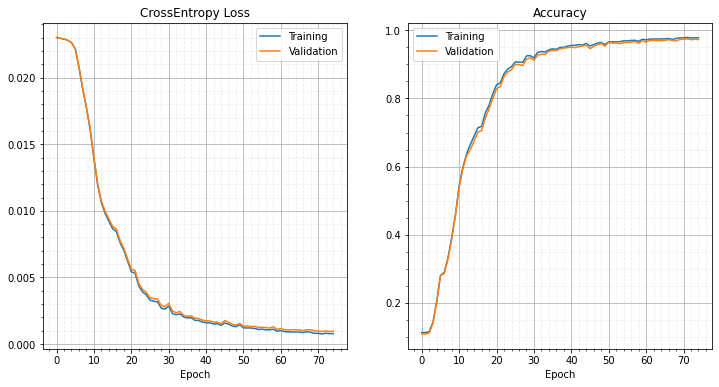

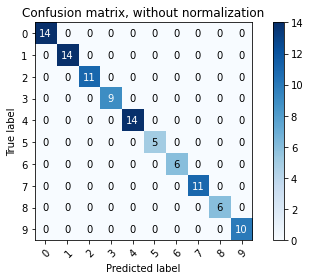

In [ ]:
batch_size = 100 
lr = 0.01 

data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

model = GRU(input_size, hidden_size, num_layers, num_classes)
best_model, best_val_accuracy, logger = train(model,lr=lr, nb_epochs=75,data_loader_train=data_loader_train, data_loader_val=data_loader_val)
logger.plot_loss_and_accuracy()
print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

accuracy_test, loss_test, misclassified_samples = accuracy_and_loss_whole_dataset(data_loader_test, best_model, True)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

# Transformer

https://github.com/lucidrains/vit-pytorch
https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0

In [ ]:
!pip3 install vit-pytorch

In [ ]:
from vit_pytorch import ViT
import torch.nn.functional as F


In [ ]:

def accuracy_and_loss_whole_dataset(data_loader, model, isTest):
  loss     = 0.
  criterion = nn.CrossEntropyLoss()
  n_correct = 0
  n_samples = 0

  model.train()
  
  with torch.no_grad():

      for data, labels in data_loader:
        
          output = F.log_softmax(model(data), dim=1)


          loss += F.nll_loss(output, labels)

          _, predicted = torch.max(output.data, 1)

          n_samples += output.shape[0]
          n_correct += (predicted == labels).sum().item()

      loss = loss / float(n_samples)

      acc =  n_correct / n_samples
      del n_samples

      if isTest:
        plot_confusion_matrix(labels, predicted, classes= [0,1,2,3,4,5,6,7,8,9],title='Confusion matrix, without normalization')


      return acc, loss

In [ ]:
def train_epoch(model, lr=0.1, nb_epochs=1, seed=None, data_loader_train=None, data_loader_val=None):
    best_model = None
    best_test_accuracy = 0
    best_accuracy = 0
    logger = Logger()



    t0 = time.time()
    for epoch in tqdm(range(nb_epochs)):
        if epoch > 0:
          total_samples = len(data_loader_train.dataset)
          model.train()
          for i, (data, label) in enumerate(data_loader_train):

              optimizer.zero_grad()
              output = F.log_softmax(model(data), dim=1)
              loss = F.nll_loss(output, label)
              loss.backward()
              optimizer.step()


        accuracy_train, loss_train,  = accuracy_and_loss_whole_dataset(data_loader_train, model, False)
        accuracy_val, loss_val,  = accuracy_and_loss_whole_dataset(data_loader_val, model, False)
        
        if accuracy_val > best_accuracy:
          best_model = model
          best_val_accuracy = accuracy_val

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        if epoch % 1 == 0: 
          print(f"Epoch {epoch:2d}, \
                  Train: loss={loss_train:.3f}, accuracy={accuracy_train*100:.1f}%, \
                  Valid: loss={loss_val:.3f}, accuracy={accuracy_val*100:.1f}%", flush=True)
          


    t1 = time.time()
    print('\n The total time for training in seconds is')
    print(t1-t0)

    return best_model, best_val_accuracy, logger







  0%|          | 0/10 [00:00<?, ?it/s]

Epoch  0,                   Train: loss=0.025, accuracy=10.2%,                   Valid: loss=0.025, accuracy=10.1%







 10%|█         | 1/10 [01:33<14:02, 93.57s/it]

Epoch  1,                   Train: loss=0.002, accuracy=93.3%,                   Valid: loss=0.002, accuracy=93.0%







 20%|██        | 2/10 [06:41<21:03, 157.92s/it]

Epoch  2,                   Train: loss=0.002, accuracy=95.1%,                   Valid: loss=0.002, accuracy=94.6%







 30%|███       | 3/10 [11:53<23:48, 204.09s/it]

Epoch  3,                   Train: loss=0.001, accuracy=95.7%,                   Valid: loss=0.002, accuracy=95.0%







 40%|████      | 4/10 [17:09<23:46, 237.69s/it]

Epoch  4,                   Train: loss=0.001, accuracy=96.4%,                   Valid: loss=0.001, accuracy=95.7%







 50%|█████     | 5/10 [22:28<21:49, 261.95s/it]

Epoch  5,                   Train: loss=0.001, accuracy=96.3%,                   Valid: loss=0.001, accuracy=95.7%







 60%|██████    | 6/10 [27:44<18:33, 278.38s/it]

Epoch  6,                   Train: loss=0.001, accuracy=97.5%,                   Valid: loss=0.001, accuracy=96.8%







 70%|███████   | 7/10 [33:02<14:30, 290.15s/it]

Epoch  7,                   Train: loss=0.001, accuracy=97.3%,                   Valid: loss=0.001, accuracy=96.6%







 80%|████████  | 8/10 [38:17<09:55, 297.58s/it]

Epoch  8,                   Train: loss=0.001, accuracy=97.6%,                   Valid: loss=0.001, accuracy=96.8%







 90%|█████████ | 9/10 [43:32<05:02, 302.89s/it]

Epoch  9,                   Train: loss=0.001, accuracy=98.3%,                   Valid: loss=0.001, accuracy=97.2%







100%|██████████| 10/10 [48:48<00:00, 292.86s/it]


 The total time for training in seconds is
2928.563238143921
Best validation accuracy = 97.200


Confusion matrix, without normalization
Evaluation of the best training model over test set
------
Loss : 0.001
Accuracy : 97.450


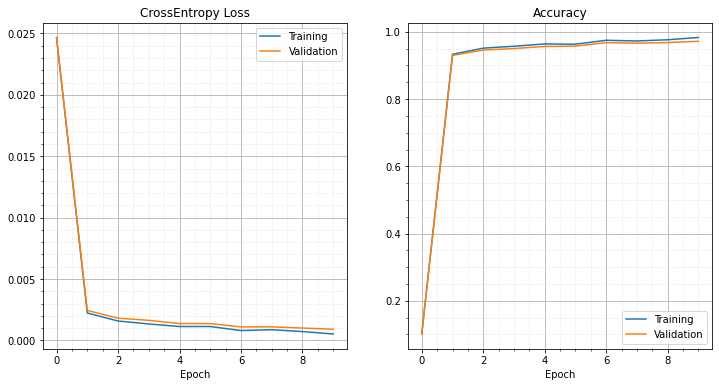

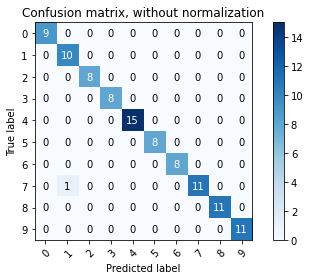

In [ ]:

data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=100)

model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

best_model, best_val_accuracy, logger = train_epoch(model,lr=0.003, nb_epochs=10,data_loader_train=data_loader_train, data_loader_val=data_loader_val)

logger.plot_loss_and_accuracy()
print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model, True)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

In [ ]:
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)

s(model, torch.zeros((1, 1, 28, 28)))


                                                 Kernel Shape   Output Shape  \
Layer                                                                          
0_to_patch_embedding.Rearrange_0                            -    [1, 16, 49]   
1_to_patch_embedding.Linear_1                        [49, 64]    [1, 16, 64]   
2_dropout                                                   -    [1, 17, 64]   
3_transformer.layers.0.0.fn.LayerNorm_norm               [64]    [1, 17, 64]   
4_transformer.layers.0.0.fn.fn.Linear_to_qkv       [64, 1536]  [1, 17, 1536]   
5_transformer.layers.0.0.fn.fn.to_out.Linear_0      [512, 64]    [1, 17, 64]   
6_transformer.layers.0.0.fn.fn.to_out.Dropout_1             -    [1, 17, 64]   
7_transformer.layers.0.1.fn.LayerNorm_norm               [64]    [1, 17, 64]   
8_transformer.layers.0.1.fn.fn.net.Linear_0         [64, 128]   [1, 17, 128]   
9_transformer.layers.0.1.fn.fn.net.GELU_1                   -   [1, 17, 128]   
10_transformer.layers.0.1.fn.fn.net.Drop

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_to_patch_embedding.Rearrange_0,-,"[1, 16, 49]",NaN,NaN
1_to_patch_embedding.Linear_1,"[49, 64]","[1, 16, 64]",3200.0,3136.0
2_dropout,-,"[1, 17, 64]",NaN,NaN
3_transformer.layers.0.0.fn.LayerNorm_norm,[64],"[1, 17, 64]",128.0,64.0
4_transformer.layers.0.0.fn.fn.Linear_to_qkv,"[64, 1536]","[1, 17, 1536]",98304.0,98304.0
...,...,...,...,...
61_transformer.layers.5.1.fn.fn.net.Linear_3,"[128, 64]","[1, 17, 64]",8256.0,8192.0
62_transformer.layers.5.1.fn.fn.net.Dropout_4,-,"[1, 17, 64]",NaN,NaN
63_to_latent,-,"[1, 64]",NaN,NaN
